<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Market_Return_by_Dates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

14:40:38 Starting...
14:40:38 Installing yfinance into Google notebook...
14:40:48 Installing arch into Google notebook...
14:40:59 Initialized.


## Get the Data

In [2]:
data,ticker_name=download(ticker:='SPY',auto_adjust=True).xs(ticker,axis=1,level=1),'S&P 500 Index ETF'
data['Return']=data['Close'].pct_change()*hundred
data.columns.name=ticker_name
data.dropna(inplace=True)
data.index=list(map(lambda x:pd.Period(x,'D'),data.index))
data['Weekday']=data.index.weekday+1
data['Monthday']=data.index.day
data['DaysInMonth']=list(map(lambda x:pd.Period(x,'M').daysinmonth,data.index))
data['Month']=data.index.month
display(data)

[*********************100%***********************]  1 of 1 completed


S&P 500 Index ETF,Close,High,Low,Open,Volume,Return,Weekday,Monthday,DaysInMonth,Month
1993-02-01,24.626431,24.626431,24.469907,24.469907,480500,0.711255,1,1,28,2
1993-02-02,24.678610,24.696001,24.556869,24.609044,201300,0.211883,2,2,28,2
1993-02-03,24.939480,24.956871,24.695998,24.713390,529400,1.057069,3,3,28,2
1993-02-04,25.043823,25.095998,24.748167,25.026432,531500,0.418386,4,4,28,2
1993-02-05,25.026432,25.078607,24.887300,25.026432,492100,-0.069443,5,5,28,2
...,...,...,...,...,...,...,...,...,...,...
2025-04-10,524.580017,533.500000,509.320007,532.169983,162331200,-4.381900,4,10,30,4
2025-04-11,533.940002,536.429993,520.070007,523.010010,97866300,1.784282,5,11,30,4
2025-04-14,539.119995,544.280029,533.859985,544.049988,68034000,0.970145,1,14,30,4
2025-04-15,537.609985,543.229980,536.809998,539.669983,56628300,-0.280088,2,15,30,4


## Analyse Returns by Day of the Week
### First Just a Simple Grouped Mean

15:09:45 t Test for a Zero Mean


S&P 500 Index ETF,Mean,Std.Dev.,Count,Std.Err.,t Statistic,p Value
Day of Week,,,,,,
Monday,0.047251,1.292801,1523,0.033127,1.426347,0.153973
Tuesday,0.071261,1.173253,1665,0.028753,2.478387,0.013296
Wednesday,0.057872,1.147147,1663,0.028130,2.057285,0.039815
Thursday,0.014281,1.180170,1633,0.029205,0.488985,0.624918
Friday,0.033504,1.110541,1625,0.027549,1.216145,0.224106


15:09:46 Wrote plot to Average Returns of S&P 500 Index ETF by Day of the Week.png.
15:09:46 One Way ANOVA Analysis by Day of the Week


,Sum of Squares,d.o.f.,F Statistic,p Value,Significance
Variation,,,,,
Between Groups,1.200533,1.0,0.861354,0.353388,
Within Groups,11299.324919,8107.0,,,


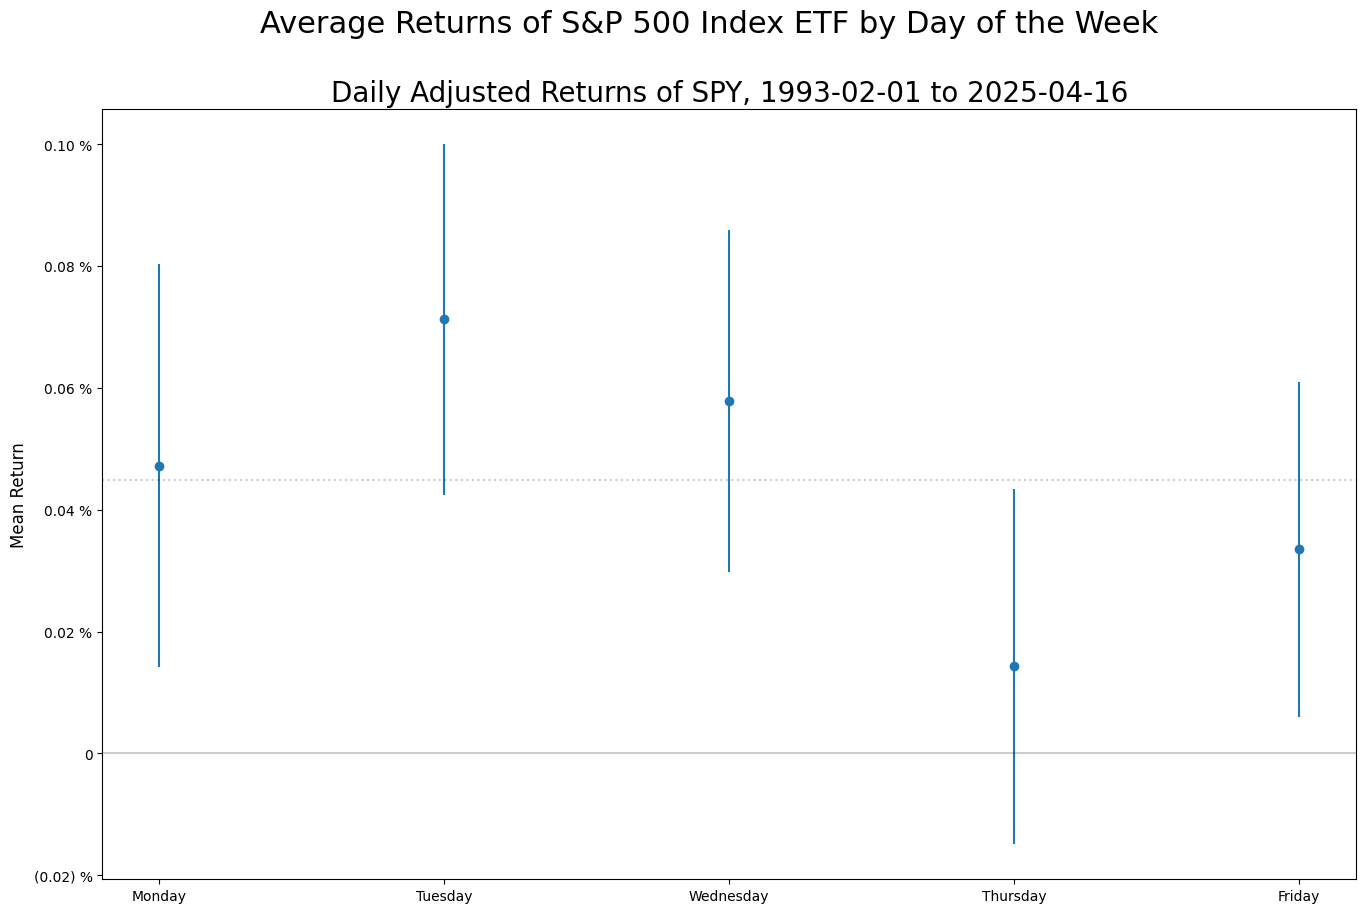

In [26]:
from scipy.stats import t as studentt
from statsmodels.formula.api import ols as OLSformula
from statsmodels.stats.anova import anova_lm

nprint("t Test for a Zero Mean")
results=(grouped:=data[['Return','Weekday']].groupby("Weekday")).mean().rename(columns={'Return':'Mean'})
results['Std.Dev.']=grouped.std()
results['Count']=grouped.count()
results['Std.Err.']=results['Std.Dev.']/np.sqrt(results['Count'])
results['t Statistic']=results['Mean']/results['Std.Err.']
results['p Value']=studentt.sf(np.abs(results['t Statistic']),results['Count']-1)*2
results.index=["Monday","Tuesday","Wednesday","Thursday","Friday"]
results.index.name='Day of Week'
display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index,y:=results['Mean'],ye:=results['Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Average Returns of {} by {}".format(ticker_name,group_name:="Day of the Week"),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

nprint("One Way ANOVA Analysis by {}".format(group_name))
fit=OLSformula("Return ~ Weekday",data).fit()
anova=anova_lm(fit,typ=2).rename(columns={'sum_sq':'Sum of Squares','df':'d.o.f.','PR(>F)':'p Value','F':'F Statistic'})
anova['Significance']=anova['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
anova.index=['Between Groups','Within Groups']
anova.index.name='Variation'
display(anova.replace(np.nan,""))

### Now do an OLS with Indicator Variables
This will deliver *exactly* the same results as the grouped means, but with some other statistics for "free."

In [27]:
from statsmodels.regression.linear_model import OLS

nprint("Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.")
display(design:=pd.get_dummies(data['Weekday'],columns=['Weekday'],dtype=float).merge(data['Return'],left_index=True,right_index=True).rename(columns=dict(zip(range(1,1+len(results.index)),results.index))))
fit=ols_fit=OLS(design['Return'],design.drop('Return',axis=1)).fit()
nprint(fit.summary())

15:09:46 Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.


,Monday,Tuesday,Wednesday,Thursday,Friday,Return
1993-02-01,1.0,0.0,0.0,0.0,0.0,0.711255
1993-02-02,0.0,1.0,0.0,0.0,0.0,0.211883
1993-02-03,0.0,0.0,1.0,0.0,0.0,1.057069
1993-02-04,0.0,0.0,0.0,1.0,0.0,0.418386
1993-02-05,0.0,0.0,0.0,0.0,1.0,-0.069443
...,...,...,...,...,...,...
2025-04-10,0.0,0.0,0.0,1.0,0.0,-4.381900
2025-04-11,0.0,0.0,0.0,0.0,1.0,1.784282
2025-04-14,1.0,0.0,0.0,0.0,0.0,0.970145
2025-04-15,0.0,1.0,0.0,0.0,0.0,-0.280088


15:09:46                             OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5716
Date:                Wed, 16 Apr 2025   Prob (F-statistic):              0.683
Time:                        15:09:46   Log-Likelihood:                -12851.
No. Observations:                8109   AIC:                         2.571e+04
Df Residuals:                    8104   BIC:                         2.575e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday         0.0473      0.030      1.562

### Now fit a GJR-GARCH(1,1,1) Model with the Same Dummies and Non-Normal Innovations
This is a _way more accurate_ distributional model that the Normal model assumed by OLS. It will weight high-volatility days appropriately.

15:49:49 Fitting GJR-GARCH(1,1,1) Model with GED Innovations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10682.47539992052
            Iterations: 19
            Function evaluations: 238
            Gradient evaluations: 19
15:49:50                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                      -0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -10682.5
Distribution:      Generalized Error Distribution   AIC:                           21385.0
Method:                        Maximum Likelihood   BIC:                           21455.0
                                                    No. Observations:                 8109
Date:                            Wed, Apr 16 2025   Df Residuals:                  

,Estimate,Std.Err.,Null Value,t Score,p Value
Monday,0.067838,0.018196,0.0,3.728257,0.000193
Tuesday,0.033638,0.018500,0.0,1.818295,0.069019
Wednesday,0.073814,0.016719,0.0,4.414867,0.00001
Thursday,0.045390,0.020046,0.0,2.26425,0.023559
Friday,0.072727,0.017717,0.0,4.104896,0.00004
omega,0.018934,0.003522,,,
alpha[1],0.000676,0.007224,,,
gamma[1],0.192984,0.022535,,,
beta[1],0.886085,0.013421,,,
nu,1.360207,0.034978,2.0,-18.291057,0.0


15:49:51 Wrote plot to Estimated Returns of S&P 500 Index ETF by Day of the Week.png.


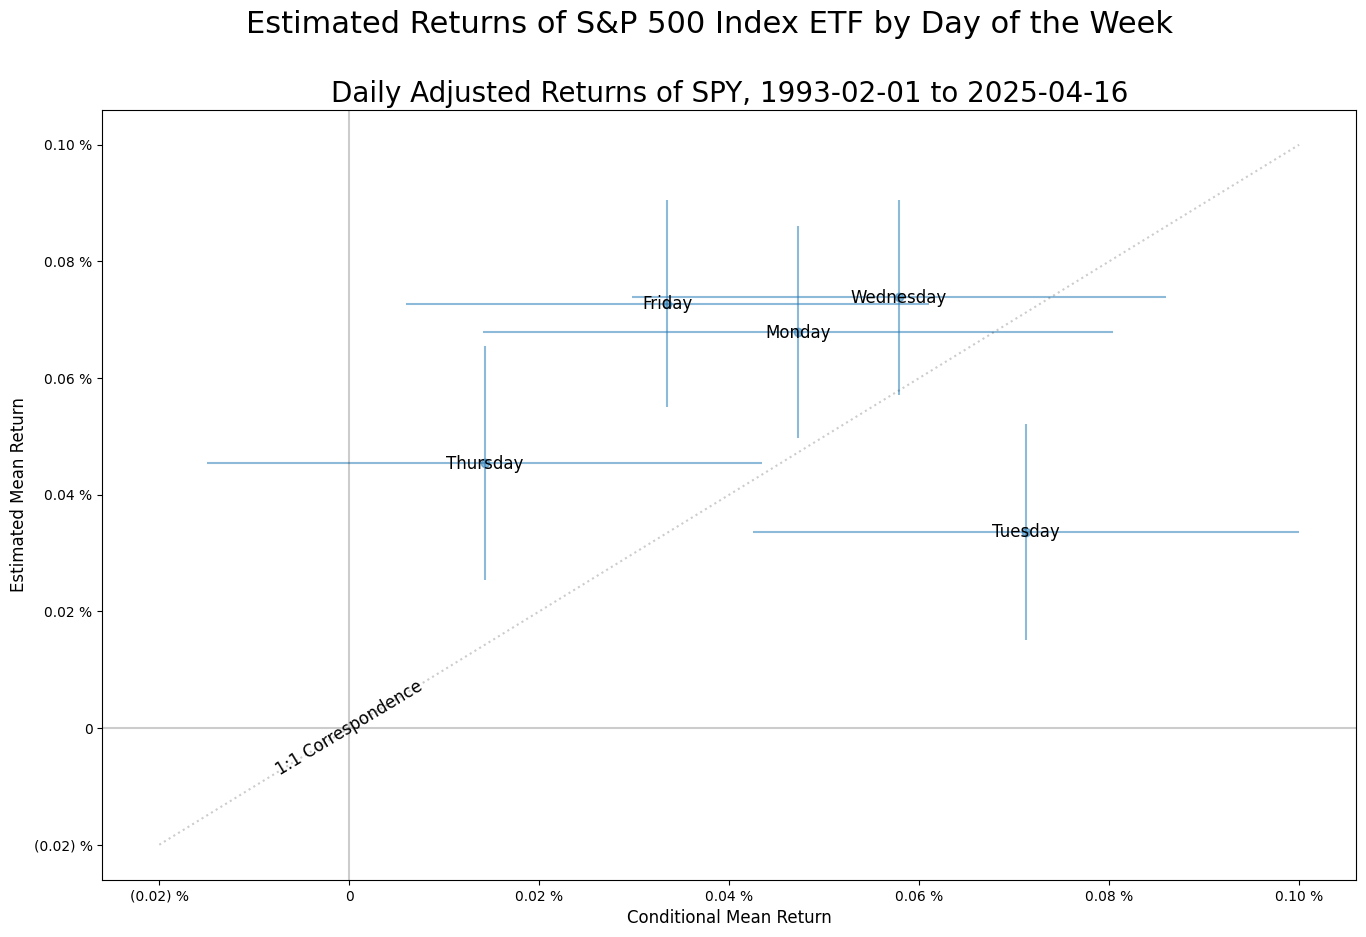

In [63]:
from scipy.stats import norm

nprint("Fitting GJR-GARCH(1,1,1) Model with GED Innovations")
model=ARX(design["Return"],design.drop('Return',axis=1),constant=False)
model.volatility=GARCH2(1,1,1)
model.distribution=GeneralizedError2()
fit=gjr_fit=model.fit(update_freq=0)
nprint(gjr_fit.summary())
data['Volatility']=gjr_fit.conditional_volatility

results=pd.DataFrame({'Estimate':fit.params,'Std.Err.':fit.std_err,'Null Value':[zero]*(len(fit.params)-5)+[np.nan]*4+[two]})
results['t Score']=(results['Estimate']-results['Null Value'])/results['Std.Err.']
results['p Value']=list(map(lambda x:min(norm.cdf(x),norm.sf(x))*two,results['t Score']))
display(results.replace(np.nan,""))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(xx:=y,yy:=results.loc[x,'Estimate'],xerr=ye,yerr=results.loc[x,'Std.Err.'],fmt='o',alpha=0.5)

for day in x:
  plot.text(xx.loc[day],yy.loc[day],day,ha='center',va='center',fontsize=12)

plot.plot(r:=[min([-0.02,xx.min(),yy.min()]),max([0.1,xx.max(),yy.max()])],r,':',color='black',alpha=0.2)
plot.text(zero,zero,'1:1 Correspondence',fontsize=12,ha='center',va='center',rotation=31)
plot.axhline(color='black',alpha=0.2)
plot.axvline(color='black',alpha=0.2)
plot.set_xlabel("Conditional Mean Return",fontsize=12)
plot.set_ylabel("Estimated Mean Return",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(2))
plot.yaxis.set_major_formatter(PercentLabels(2))
figure.suptitle(title:="Estimated Returns of {} by {}".format(ticker_name,group_name:="Day of the Week"),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

np.float64(28.0)